# Assested Exercise

### Student: Damiano Franzò

The Notebook is divided in the following sections:
- [0. Environment Setup](#0.-Environment-Setup)
- [1. Dataset Setup](#1.-Dataset-Setup) 
- [2. Distribution Analysis](#2.-Distribution-Analysis)
- [3. Bayesian Linear Regression](#3.-Bayesian-Linear-Regression)
    - [3.a Bayesian linear regression Implementation](#3.a-Bayesian-linear-regression-Implementation)
    - [3.b Gaussian Prior Parameters choice](#3.b-Gaussian-Prior-Parameters-choice)
    - [3.c Nth order polynomial](#3.c-Nth-order-polynomial)
    - [3.d Data Preprocessing](#3.d-Data-Preprocessing)
    - [3.e Treat data as continuous](#3.e-Treat-data-as-continuous)
    - [3.f Discretize Predictions](#3.f-Discretize-Predictions)
    - [3.g Comparison vs Random Classifier](#3.g-Comparison-vs-Random-Classifier)
- [4. Logistic Regression](#4.-Logistic-Regression)
    - [4.a Bayesian Logistic Regression](#4.a-Bayesian-Logistic-Regression)
    - [4.b Gradient Descent](#4.b Gradient Descent)
    - [4.c Convexity of the problem](#4.c-Convexity-of-the-problem)
    - [4.d Comparison with Bayesian Linear Regression Classifier](#4.d-Comparison-with-Bayesian-Linear-Regression-Classifier)
    - [4.e Laplace Approximation](#4.e-Laplace-Approximation)
- [5. Bonus Question](#5.-Bonus-Question)
- [Addictional test with ADAM](#Addictional-test-with-ADAM)

### 0. Environment Setup
Import of used libraries, modules and functions

In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

### 1. Dataset Setup

In [2]:
# read the csv dataset
df = pd.read_csv('./train.csv')

In [3]:
# Visualizing some rows of the dataset
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
df = df.set_index('ID_code')
# it is the label indicating wheter the sample is a fraud or not
y = df['target']
X = df.drop(['target'], axis=1)

In [6]:
# Stratify option assures that the proportion of 0 and 1 are mantained the same between test and train dataset
# this option is extremely useful dealing imbalanced dataset
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

### 2. Distribution Analysis
Below is displayed the distribution of labels within the dataset.

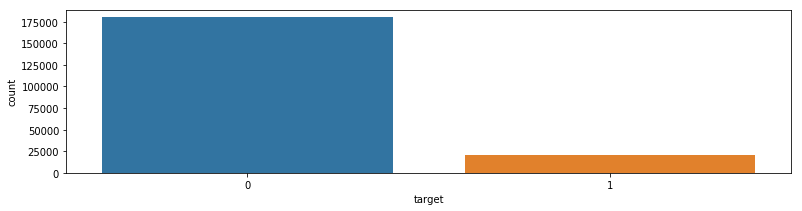

In [7]:
fig, ax = plt.subplots(figsize=(13, 3))

# TR the count is computed automatically
g = sns.countplot(x='target', data=df)

plt.show()

Is it possible to notice that the dataset is clearly imbalanced. Without the proper adjustements some of machine learning models could be biases toward the classification of *0* respect to *1*.  
In addiction to that, a proper consideration has to be done on the choice of evaluation metrics since the *accuracy* is not completely reliable. 
A dummy classifier can classify every sample with label *0* getting ~90% accuracy, but this does not imply it is a smart classifier. On the other hand, two interesting metrics can be *f1_score (macro)* and *f1_score (binary on the worst case)*.

### 3. Bayesian Linear Regression

In [405]:
# The dataframe is transformed into a numpy.matrix
X_train, X_test = np.matrix(X_train_df.values), np.matrix(X_test_df.values)
y_train, y_test = np.matrix(y_train_df).T, np.matrix(y_test_df).T

#### 3.a Bayesian linear regression Implementation
Above there is a recap on Bayesian Linear regression related formulas.  
The method names are as much as possible coherent with their meaning in the context of the implementation of the formulas.

#### Recap of some formulas

##### Prior
$p(w) = \mathcal{N}(0, S)$


##### Parameters
$ \hat{w} = (X^tX)^{-1} X^Tt$  
$ \hat{\sigma^2} = \frac{1}{N}(t - Xw)^T(t - Xw) $  

$\Sigma = (\frac{1}{\sigma^2} X^{\intercal}X + S^{-1})^{-1}$       
$\mu = \frac{1}{\sigma^2} \Sigma X^{\intercal}t$  
##### Posterior
$p(w| X,t,\sigma^2) = \mathcal{N}(\mu,\Sigma)$

##### Prediction, density function
$p(t_{new}| X, t, x_{new}, \sigma^2) = \mathcal{N}(x_{new}^T \mu, \sigma^2 +  x_{new}^T \Sigma  x_{new})$

In [70]:
# Utility functions used for the Bayesian Linear Regression
def get_w_hat(X, t):
    xt_x_minus_one = np.linalg.inv(np.dot(X.T, X))
    xt_t = np.dot(X.T, t)
    w_hat = np.dot(xt_x_minus_one, xt_t)
    return w_hat

def get_sigma_hat(w, X, t, N):
    X_w = np.dot(X, w)
    t_minus_X_w = (t - X_w)
    sigma_hat = (1. / N) * np.dot(t_minus_X_w.T, t_minus_X_w)
    return np.float(sigma_hat)

def get_Sigma_w(sigma_square, X, S):
    return np.linalg.inv((1. / sigma_square) * np.dot(X.T, X) + np.linalg.inv(S))

def get_mean_w(sigma_square, Sigma, X, t):
    return (1. / (sigma_square)) * np.dot(np.dot(Sigma, X.T), t)

In [281]:
class BayesianLinearRegressor:
    def __init__(self, n=1, sigma_unif=1.):
        self.n = n
        self.sigma_unif = sigma_unif

    def lrfit(self, X_, t):
        X = get_X_powered(X_, self.n)
        X = get_X_w_bias(X)

        _, S = generate_prior(X.shape[1], sigma_unif=self.sigma_unif)

        w_hat = get_w_hat(X, t)

        sigma_square = get_sigma_hat(w_hat, X, t, X.shape[0])

        Sigma = get_Sigma_w(sigma_square, X, S)

        mean_w = get_mean_w(sigma_square, Sigma, X, t)

        self.mean_w, self.sigma_square, self.Sigma = mean_w, sigma_square, Sigma
    
    def predict(self, X):
        X_pow = get_X(X, self.n)

        return np.dot(X_pow, self.mean_w)

#### 3.b Gaussian Prior Parameters choice
In the challenge web page it is written: *You are provided with an anonymized dataset containing numeric feature variables*  
Therefore, actually you do not have **no prior belief** on the weights of the classifier. Usually, when instead you have prior beliefs on weights, you can use these information to **encode** them into the prior.  

Since the prior is an distribution you state **before** looking into the data, it should not be possible(philosophically correct) to do cross validation on it. We can you do, it is just an usage of a *weakily infomative prior*, where you do not force weights to range across tight intervals.

In this case, a Gaussian Prior is a reasonable choice

#### 3.c Nth order polynomial

In [541]:
def get_X_powered(X, n):
    """
    Return the X matrix concat with all the samples powered to 2..n
    
    Args:
        X (numpy.matrix): Matrix (N, D)
            - N : number of rows
            - D : number of features
        n (str): The power of the matrix.

    Returns:
        X_result: Matrix X with all the n powers
    """
    if n <= 1:
        return X
    X_result = deepcopy(X)
    X_powered = deepcopy(X)
    for i in range(2, n + 1):
        X_powered = np.multiply(X_powered, X)
        X_result = np.concatenate((X_result, X_powered), axis=1)
    return X_result

def get_X_w_bias(X):
    """
    Return The X matrix with the bias term
    
    Args:
        X (numpy.matrix): Matrix X (N, D)
    
    Returns:
        X_result (numpy.matrix): Matrix X (N, D + 1) with bias term put on the right column
    """
    X_result = np.concatenate((X, np.matrix(np.ones((X.shape[0]))).T), axis=1)
    return X_result

def get_X(X, n=1):
    """
    Put together the 2 functions above since they are often used together
    """
    return get_X_w_bias(get_X_powered(X, n))

def generate_prior(features, sigma_unif=3.):
    S = np.matrix(np.diag(sigma_unif * np.ones(features)))
    return np.matrix(np.zeros(features)), S

In [542]:
def print_err(y_pred, y, total=False):
    """
    Display the error of the Regression predictions
    """
    err = y - y_pred
    tot_err = np.sum(np.multiply(err, err))
    if total:
        print("Total squared error: {}".format(tot_err))
    else:
        print("Average squared error: {}".format(tot_err / len(y)))
    print("\n")

In [543]:
def sigmoid(x):
    return 1./ (1. + np.exp(-x))

@np.vectorize
def discretize(pred, threshold=0.5):
    """
    The decorator vectorize allows to apply the function to each element
    """
    return 1 if pred > threshold else 0 

#### 3.d Data Preprocessing
As discussed before, the dataset is anomized, so there are no way to encode domain knowledge into the data preprocessing of the dataset. Nevertheless, some data preprocessing techiques are still possible:
- **Checking**: First of all a check on the ranges, missing values can be always done, you do not need domain knowledge on features to do that.  

- **Normalize**: Most of the times there are no reason to **not** normalize the dataset, since experimentally it is a great method to dampen order of magnitude differences, and also in the first steps of some training models, it is a great way to avoid exploding gradient and vanishing gradient  

- **Analyze distribution**: Even if features do not permit to explain domain knowledge, this does not exclude that some columns prenst some **statistical** property. Many times this can be done analyzing the distribution of some feature and from that you can state some hypotesis on preprocessing and test how the model behaves.

C:\Users\fullo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


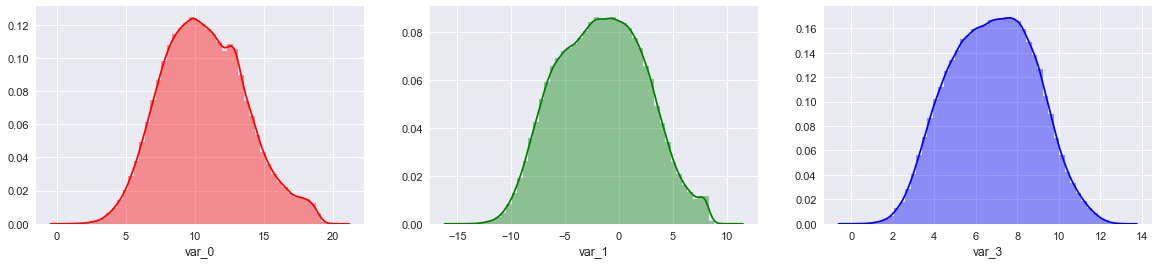

In [564]:
# Example of Analysis distribution
fig, ax = plt.subplots(ncols=3, figsize=(20, 4))

sns.distplot(df['var_0'], ax=ax[0], color='red')
sns.distplot(df['var_1'], ax=ax[1], color='green')
sns.distplot(df['var_3'], ax=ax[2], color='blue')

plt.show()

The distributions "look like" gaussian, so a possible preprocessing can be just the normalization of those features.

#### 3.e Treat data as continuous

In [285]:
blr = BayesianLinearRegressor(n=3)

blr.lrfit(X_train, y_train)
y_test_und = blr.predict(X_test)
print_err(y_test_und, y_test, True)

Total squared error: 6830.479805772059




In [567]:
# Posterior Variance
posterior_variance = blr.Sigma
print("Posterior variance matrix with shape: ", posterior_variance.shape)

Posterior variance matrix with shape:  (201, 201)


#### 3.f Discretize Predictions

In [568]:
def print_metrics(y_test, y_pred):
    """
    Utility function to display the most important metrics
    """
    print("Weighted score: ", f1_score(y_test, y_pred, average='weighted'))
    print("Macro score: ", f1_score(y_test, y_pred, average='macro'))
    print("Binary 0 score: ", f1_score(y_test, y_pred, pos_label=0))
    print("Binary 1 score: ", f1_score(y_test, y_pred, pos_label=1))
    print("F1 classic score: ", f1_score(y_test, y_pred))
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("\n")

In theory, a naive approach to discretize the prediction is to use 0.5 as threshold to separate 0 from 1. Nevertheless, we cannot exclude that other thresholds can produce different perfromance across different metrics.

In [304]:
y_pred = discretize(y_test_und, 0.5)

print_metrics(y_pred, y_test)

Weighted score:  0.9424223759253363
Macro score:  0.5919987798441559
Binary 0 score:  0.953014579486853
Binary 1 score:  0.23098298020145885
F1 classic score:  0.23098298020145885
Accuracy:  0.91144




To test different approaches we cannot test the best threshold for the test prediction, since it can be lead to overfitting without we can even notice it. The approach adopted is Cross Validation on the threshold.

In [303]:
def threshold_cross_validation_lg(X_train, y_train, metric_f, n=1, k=10):
    treshoold_linspace = np.linspace(0, 1, 101)[1:-1] #no sense to take extremis
    fold = list(range(k))

    # Utility variables
    fold = list(range(k)) # folds
    bs = len(X_train) // 10 # batch size
    tot_len = len(X_train) # total number of samples
    best_thresholds = [] # best thresholds for each fold

    for i in fold:
        X_validation = X_train[i * bs : (i + 1) * bs]
        X_train_fold = np.concatenate((X_train[0 : i * bs], X_train[(i + 1) * bs : tot_len]))
        
        y_validation = y_train[i * bs : (i + 1) * bs]
        y_train_fold = np.concatenate((y_train[0 : i * bs], y_train[(i + 1) * bs : tot_len]))
        
        blr = BayesianLinearRegressor(n=n)

        blr.lrfit(X_train_fold, y_train_fold)
        
        y_pred_undiscretized = blr.predict(X_validation)
        
        maximum_metric = 0.
        best_thd = 0.

        for thr in treshoold_linspace:
            y_pred = discretize(y_pred_undiscretized, thr)

            metric = metric_f(y_validation, y_pred)
            if metric > maximum_metric:
                maximum_metric = metric
                best_thr = thr
                
        best_thresholds.append(best_thr)
        print("best threshold fold {}: {}".format(i, best_thr))
    return np.median(best_thresholds)

The code above allows to optimize *any* metric, just through the usage of a lambda function on the metric. We want to maximize *f1 score*. We take the median in order to avoid screwed result.

In [305]:
metric_f = lambda true, pred : f1_score(true, pred)

bthr = threshold_cross_validation_lg(X_train, y_train, metric_f, n=3, k=10)

y_pred = discretize(y_test_und, bthr)

print_metrics(y_pred, y_test)

C:\Users\fullo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best threshold fold 0: 0.29
best threshold fold 1: 0.31
best threshold fold 2: 0.31
best threshold fold 3: 0.29
best threshold fold 4: 0.28
best threshold fold 5: 0.29
best threshold fold 6: 0.29
best threshold fold 7: 0.3
best threshold fold 8: 0.28
best threshold fold 9: 0.29
Weighted score:  0.9072930504902521
Macro score:  0.7515529706893749
Binary 0 score:  0.9488621479569941
Binary 1 score:  0.5542437934217558
F1 classic score:  0.5542437934217558
Accuracy:  0.90825




The f1 score obtained is 0.55, which is maximized respect to the threshold.

In [306]:
def get_confusion_matrix(y_test, y_pred):
    conf = np.array([[0, 0], [0, 0]])

    conc = np.concatenate((y_test, y_pred), axis=1)

    # we consider 0 as Positive for semplicity
    for a in conc:
        val_true, val_pred = a.item(0), a.item(1)
        if val_true == val_pred:
            # True Positive
            if val_pred == 0:
                conf[0][0] += 1
            # True Negative
            else:
                conf[1][1] += 1
        if val_true != val_pred:
            # False positive
            if val_pred == 0:
                conf[0][1] += 1
            # False negative
            else:
                conf[1][0] += 1
    return conf

In [308]:
def plot_confusion_matrix(y_test, y_pred):
    conf = get_confusion_matrix(y_test, y_pred)
    conf_normalized = 100. * conf / np.sum(conf, axis=0)

    fig,ax = plt.subplots(ncols=2, figsize=(20, 4))

    sns.heatmap(conf, ax=ax[0], annot=True)
    sns.heatmap(conf_normalized, ax=ax[1], annot=True)


    ax[0].set(xticklabels=[0, 1], yticklabels=[0, 1],
       title='confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
    ax[1].set(xticklabels=[0, 1], yticklabels=[0, 1],
       title='Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
    sns.set(font_scale=1.1)

    plt.show()

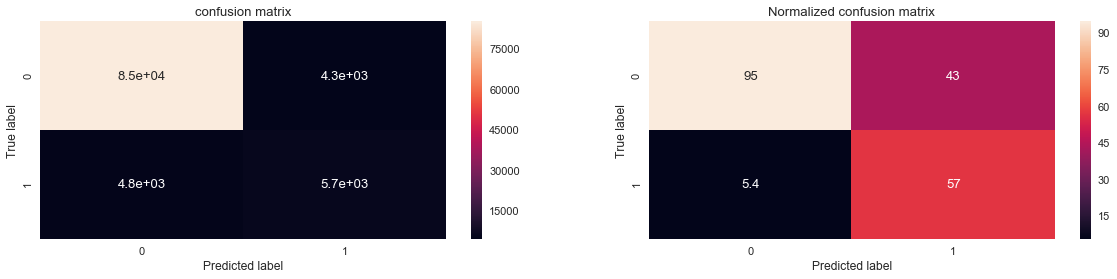

In [310]:
plot_confusion_matrix(y_test, y_pred)

N.B. The accuracy is reported above on the print of the metrics

#### 3.g Comparison vs Random Classifier

In [312]:
y_pred = discretize(y_test_und, bthr)

print_metrics(y_pred, y_test)

Weighted score:  0.9072930504902521
Macro score:  0.7515529706893749
Binary 0 score:  0.9488621479569941
Binary 1 score:  0.5542437934217558
F1 classic score:  0.5542437934217558
Accuracy:  0.90825




In [289]:
random_classifier = np.matrix(np.random.rand(len(X_test), 1))

y_pred_random_classifier = discretize(random_classifier)

print_metrics(y_pred_random_classifier, y_test)

Weighted score:  0.4041036313144761
Macro score:  0.40387472493165244
Binary 0 score:  0.6423188737062409
Binary 1 score:  0.16543057615706408
F1 classic score:  0.16543057615706408
Accuracy:  0.49925




The performance are not that bad considering that they have been done considering label to be continuos.

### 4. Logistic Regression

The formulas below are **semantically** equivalent:

- $\prod{t_n p(t_n=1|x_n,w) + (1 - t_n) p(t_n=0|x_n,w)}$

- $\prod{p(t_n=1|x_n,w)^{t_n}  p(t_n=0|x_n,w) ^{(1 - t_n)}}$

So in the loss functions it is utilized the first one just for comodity

#### 4.a Bayesian Logistic Regression

In [572]:
class BayesianLogisticRegression:
    def __init__(self, num_parameters):
        self.w = torch.zeros((num_parameters, 1), requires_grad=True, dtype=torch.float64)
        self.num_parameters = num_parameters

    def forward(self, X, cuda=False):
        prod = torch.mm(X, self.w)
        return torch.sigmoid(prod)

    def predict(self, X):
        return torch.sigmoid(torch.mm(X, self.w))

    def update_model(self, lr):    
        # Update parameters
        gradients = self.w.grad.data
        with torch.no_grad():
            for idx in range(self.num_parameters):
                self.w[idx].data -= lr * gradients[idx]

def loss_function(output, t, w):
    t_float = t.type(torch.DoubleTensor)
    likelihood = t_float * output + (1 - t_float) * (1 - output)
    
    const = float((1. / np.sqrt((2 * np.pi))))
    prior =  torch.log(const * torch.exp(- w**2 / 2)).sum()
    likel = torch.log(likelihood).sum()
    return - (likel + prior)

def loss_function_weighted(output, t, weights):
    t_float = t.type(torch.DoubleTensor)
    likelihood = weights[1] * t_float * output + weights[0] * (1 - t_float) * (1 - output)
    
    const = float((1. / np.sqrt((2 * np.pi))))
    prior =  torch.log(const * torch.exp(- w**2 / 2)).sum()
    likel = torch.log(likelihood).sum()
    return - (likel + prior)

def threshold_cross_validation(X_train, y_train, metric_f, iterations, lr=1e-8, n=1, k=3, verbose=False):
    """
    Cross validation of the threeshold for logistic regression
    """
    treshoold_linspace = np.linspace(0, 1, 21)[1:-1] #no sense to take extremis
    
    # Utility variables
    fold = list(range(k))
    # batch size
    bs = len(X_train) // 10
    tot_len = len(X_train)

    maximum_metric = 0.
    
    
    best_thresholds = []

    # Split in k fold
    for i in fold:
        X_validation = X_train[i * bs : (i + 1) * bs]
        X_validation_pow = get_X(X_validation, n)
        X_train_fold = np.concatenate((X_train[0 : i * bs], X_train[(i + 1) * bs : tot_len]))
        
        y_validation = y_train[i * bs : (i + 1) * bs]
        y_train_fold = np.concatenate((y_train[0 : i * bs], y_train[(i + 1) * bs : tot_len]))
        
        model, _ = train(iterations, n, X_train_fold, y_train_fold, X_validation, y_validation, lr=lr,verbose=verbose)
    
        X_validation_torch, y_validation_torch = torch.from_numpy(X_validation_pow), torch.from_numpy(y_validation)
        y_pred_torch = model.predict(X_validation_torch)
        y_pred_undiscretized = y_pred_torch.data.numpy()
        
        best_thr = 0.
        maximum_metric = 0.

        for thr in treshoold_linspace:
            y_pred = discretize(y_pred_undiscretized, thr)

            metric = metric_f(y_validation, y_pred)
            if metric > maximum_metric:
                maximum_metric = metric
                best_thr = thr
                
        best_thresholds.append(best_thr)
        print("best threshold fold {}: {}".format(i, best_thr))
    return np.median(best_thresholds)

#### 4.b Gradient Descent

The learning rate suggested in the method, is the one best suited for dimension 1. In the code below there is no explicit cross validation or showing the effectiveness of this values. What I have experienced is that using an higher learning rate leads to explosion gradient wheter using a lower one leads to underfitting and slow loss decreasing.

In [414]:
def train(iterations, n, X_train, y_train, X_val, y_val, lr=1e-8, verbose=False):

    X_train_pow = get_X(X_train, n)
    X_test_pow = get_X(X_test, n)

    X_train_torch, X_test_torch = torch.from_numpy(X_train_pow), torch.from_numpy(X_test_pow)
    y_train_torch, y_test_torch = torch.from_numpy(y_train), torch.from_numpy(y_test)

    losses = []
    num_of_parameters = 200 * n + 1

    model = BayesianLogisticRegression(num_of_parameters)

    # X_train_torch, X_test_torch, y_train_torch, y_test_torch, w = X_train_torch.to('cuda'),X_test_torch.to('cuda'),y_train_torch.to('cuda'),y_test_torch.to('cuda'), w.to('cuda')
    for i in range(iterations):

        output = model.forward(X_train_torch, y_train_torch)

        loss = loss_function(output, y_train_torch, model.w)

        loss.backward()

        model.update_model(lr)

        losses.append(loss.item())

        model.w.grad.data.zero_()
        if verbose and iterations > 10 and i % (iterations // 10) == 0:
            print("Loss after another 10% of total iterations", loss.item())
    print("--Training Completed--")
    return model, losses

In [276]:
# Now we can train the model on the entire dataset
model, losses = train(10000, 1, X_train, y_train, X_test, y_test, lr=1e-8, verbose=False)

# Testing with 0.5 as threshold

y_pred_torch = model.predict(X_test_torch)
y_pred_undiscretized = y_pred_torch.data.numpy()
y_pred = discretize(y_pred_undiscretized, 0.5)

print("Metrics for 0.5 as threshold")
print_metrics(y_test, y_pred)

--Training Completed--
Metrics for 0.5 as threshold
Weighted score:  0.8877579283006667
Macro score:  0.6306147528755587
Binary 0 score:  0.9524379555802569
Binary 1 score:  0.3087915501708605
F1 classic score:  0.3087915501708605
Accuracy:  0.911




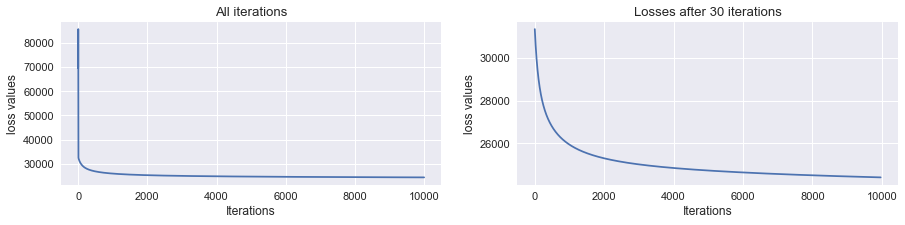

In [277]:
# Plotting losses
fig, ax = plt.subplots(ncols=2, figsize=(15, 3))

ax[0].plot(losses)
ax[0].set_title('All iterations')

ax[1].plot(losses[30:])
ax[1].set_title('Losses after 30 iterations')

for axis in ax:
    axis.set_xlabel('Iterations')
    axis.set_ylabel('loss values')

plt.show()

The first iterations are the most sensitive regarding the gradient, since it explodes if the learning rates is too high

#### 4.c Convexity of the problem
- $ log(sigmoid(w^{T}x))$ it is concave
- $ - log(sigmoid(w^{T}x))$, which can be used as the loss function is convex

Not necessary to do multiple restarts.

#### 4.d Comparison with Bayesian Linear Regression Classifier
First of all a cross validation on the Threshold is performed also for logistic regression. Basically, the output of a logistic regression classifier is a probability, se you can interpret the threshold as: *I consider a sample to be a fraud if the probability is above 30%*. Expecially in imbalanced dataset, it could lead to a better performance within certain metric.

In [317]:
# Maximize the f1 score
metric_f = lambda true, pred : f1_score(true, pred)

bthr = threshold_cross_validation(X_train, y_train, metric_f, 10000, k=5, verbose=False) # lr=1e-8, n=1

print("Best threshold obtained: {}".format(bthr))

y_pred_torch = model.predict(X_test_torch)
y_pred_undiscretized = y_pred_torch.data.numpy()
y_pred = discretize(y_pred_undiscretized, bthr)

print_metrics(y_test, y_pred)

--Training Completed--
best threshold fold 0: 0.2
--Training Completed--
best threshold fold 1: 0.2
--Training Completed--
best threshold fold 2: 0.25
--Training Completed--
best threshold fold 3: 0.25
--Training Completed--


C:\Users\fullo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best threshold fold 4: 0.2
Best threshold obtained: 0.2
Weighted score:  0.8774084911433022
Macro score:  0.6896904235545306
Binary 0 score:  0.9246258038813955
Binary 1 score:  0.45475504322766575
F1 classic score:  0.45475504322766575
Accuracy:  0.86756




This operation has been done since we want to maximize the *f1 score*. In addiction to that, the loss function **do not** encode this willing! An alternative could ne weighted loss function, but after several tests I did not obtained good results compared to this approach.

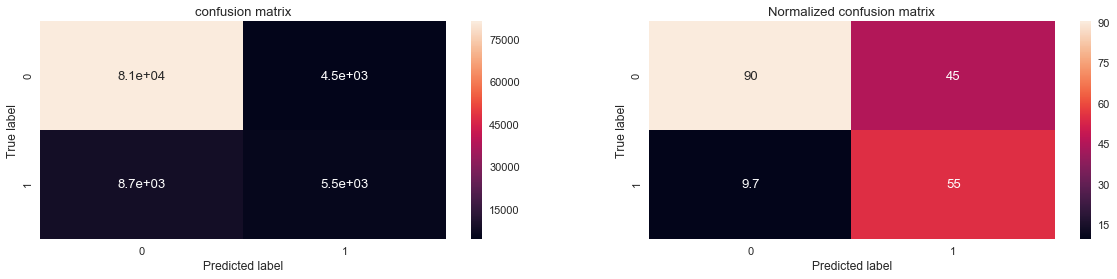

In [318]:
plot_confusion_matrix(y_test, y_pred)

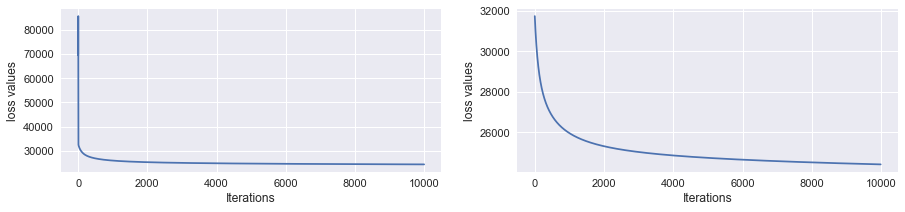

In [319]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 3))

ax[0].plot(losses)
ax[1].plot(losses[20:])

for axis in ax:
    axis.set_xlabel('Iterations')
    axis.set_ylabel('loss values')

plt.show()

N.B. Metrics of Logistic regression above

With those parameters, the Bayesian Linear regression discretize achieves better results. An hypotesis is that Bayesian Logistic regression with MAP requires more parameters tuning, and above is done just with N-th 1 power, which is not completely far to compar with a Bayesian Logistic regression with N-th 3 power.

The computation is consistently more expensive on Bayesian Logistic regression.

#### 4.e Laplace Approximation

Derivative Calculation

The steps are the ones in the following list (directly from ASI slides):
- find $ \mu = \hat{w} $ that maximises $g(w; X, t, \sigma^2)$, so we take the one we obtained in the Bayesian Logisti linear regression
- find:  $$\Sigma^{-1} = - \frac{\partial^2 log(g(w;X,t,\sigma^2))}{\partial w \partial w^T}\biggr\rvert_{\hat{w}}$$

    

So if we calculate those two elements, then it is easy to sample from $\mathcal{N}(\mu, \Sigma)$. Therefore, you an approximate the mean throught Sampling.

$$E_{\mathcal{N}(\mu, \Sigma)}[P(T_{new} = 1 | x_{new}, w] \approx \frac{1}{S} \sum_{s=1}^S{\frac{1}{1 + exp(-w^T x_{new})}}$$

Right now, we need to calculate $\frac{\partial^2 log(g(w;X,t,\sigma^2))}{\partial w \partial w^T}$, to do it we proceed element-wise and then generalizing to the N-th case

The considered likelihood is the one above (the prior term will be added afterwars):
-  $\prod{p(t_n=1|x_n,w)^{t_n}  p(t_n=0|x_n,w) ^{(1 - t_n)}}$


- first derivative:
$$\frac{\partial log(g(w;X,t,\sigma^2))}{\partial w_d} = \frac{\partial \sum_n^N{t_n log(sigm(w^T x^{(n)})) + (1 - t_n) log(1 - sigm(w^T x^{(n)}))} }{\partial w_d} -\sum_i^D{\frac{1}{2} \frac{\partial (\frac{w_i^2}{\sigma_i^2})}{\partial w_i}} $$
$$\frac{\partial log(g(w;X,t,\sigma^2))}{\partial w_d} = \sum_n^N{x_d^N (t_n - sigm(w^T x^{(n)})} + \frac{w_d}{\sigma_d^2}$$

- second derivative:

$$\frac{\partial log(g(w;X,t,\sigma^2))}{\partial w_d \partial w_e} = \sum_n^N{x_d^{(n)} x_d^{(e)} sigm(w^T x^{(n)}) (sigm(w^T x^{(n)}) - 1)} + \frac{\delta_{d,e}}{\sigma^2} I$$

- prior term second derivative with $\sigma_i=1$ for all: $- I$

Matrix form (equivalent version manually reconstructed)
$$ Sigma = -(X^T (X \odot (sigm \mathbb{1}) \odot (sigm \mathbb{1} - I) - I)^{-1}$$

##### 5. Bonus Question

In [416]:
# Now we can train the model on the entire dataset
model, _ = train(10000, 1, X_train, y_train, X_test, y_test, lr=1e-8, verbose=True)

# Testing with 0.5 as threshold

y_pred_torch = model.predict(X_test_torch)
y_pred_undiscretized = y_pred_torch.data.numpy()
y_pred = discretize(y_pred_undiscretized, 0.5)

print("Metrics for 0.5 as threshold")
print_metrics(y_test, y_pred)

Loss after another 10% of total iterations 69499.4247011653
Loss after another 10% of total iterations 25972.42964607397
Loss after another 10% of total iterations 25311.345222196047
Loss after another 10% of total iterations 25021.744076979565
Loss after another 10% of total iterations 24850.01424372001
Loss after another 10% of total iterations 24730.836806924177
Loss after another 10% of total iterations 24640.088466052843
Loss after another 10% of total iterations 24566.89119157211
Loss after another 10% of total iterations 24505.581334115195
Loss after another 10% of total iterations 24452.869746214295
--Training Completed--
Metrics for 0.5 as threshold
Weighted score:  0.8877579283006667
Macro score:  0.6306147528755587
Binary 0 score:  0.9524379555802569
Binary 1 score:  0.3087915501708605
F1 classic score:  0.3087915501708605
Accuracy:  0.911




In [606]:
w = model.w.data.numpy()

In [602]:
def get_Sigma_laplace(X, w):
    return np.dot(X.T, np.multiply(X, np.dot(sigmoid(np.dot(X, w)) - 1, np.ones((1, len(w)))))) - X.shape[0] * np.eye(w.shape[0])

In [538]:
X_test_w_b = get_X(X_test) # X_test

num_samples = 10

distr = np.random.multivariate_normal(np.squeeze(np.asarray(mean_w)), cov, num_samples)

y_storage_test = np.zeros((X_test_w_b.shape[0], 1))

for w in distr:
    w = np.matrix(w).T
    y_pred_und = sigmoid(np.dot(X_test_w_b, w))
    
    y_pred = discretize(y_pred_und, 0.2)
    
    y_storage_test += y_pred_und

y_pred = discretize(y_storage_test / num_samples, 0.2)

print("Laplace metrics")
print_metrics(y_test, y_pred)

Laplace metrics
Weighted score:  0.8772860738137028
Macro score:  0.6893114338083276
Binary 0 score:  0.9245679230143239
Binary 1 score:  0.45405494460233126
F1 classic score:  0.45405494460233126
Accuracy:  0.86745




The Performance are similar respect the ones with Bayesian Logistic Regression. The laplace approximation is not a method to provide the highest likelihood, but to provide some information respect to the variance.

##### Addictional test with ADAM

In [570]:
def train_optimizer(iterations, n, X_train, y_train, X_val, y_val, lr=1e-8, verbose=False):

    X_train_pow = get_X(X_train, n)
    X_test_pow = get_X(X_test, n)

    X_train_torch, X_test_torch = torch.from_numpy(X_train_pow), torch.from_numpy(X_test_pow)
    y_train_torch, y_test_torch = torch.from_numpy(y_train), torch.from_numpy(y_test)

    losses = []
    num_of_parameters = 200 * n + 1

    model = BayesianLogisticRegression(num_of_parameters)
    
    optimizer = torch.optim.Adam([model.w], lr=lr)

    # X_train_torch, X_test_torch, y_train_torch, y_test_torch, w = X_train_torch.to('cuda'),X_test_torch.to('cuda'),y_train_torch.to('cuda'),y_test_torch.to('cuda'), w.to('cuda')
    for i in range(iterations):
        optimizer.zero_grad()
    
        output = model.forward(X_train_torch, y_train_torch)

        loss = loss_function(output, y_train_torch, model.w)

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        model.w.grad.data.zero_()
        if verbose and iterations > 10 and i % (iterations // 10) == 0:
            print("Loss after another 10% of total iterations", loss.item())
    print("--Training Completed--")
    return model, losses

In [578]:
model, losses = train_optimizer(7000, 2, X_train, y_train, X_test, y_test, lr=1e-4, verbose=True)

Loss after another 10% of total iterations 69683.21240780623
Loss after another 10% of total iterations 24461.556156150607
Loss after another 10% of total iterations 23424.969909629544
Loss after another 10% of total iterations 22995.45226273172
Loss after another 10% of total iterations 22734.37625135978
Loss after another 10% of total iterations 22586.171717153353
Loss after another 10% of total iterations 22494.501272758713
Loss after another 10% of total iterations 22431.469514401775
Loss after another 10% of total iterations 22454.698984950363
Loss after another 10% of total iterations 22344.43767955946
--Training Completed--


In [585]:
X_test_torch = torch.from_numpy(get_X(X_test, 2))
y_pred_und = model.predict(X_test_torch).detach().numpy()

y_pred = discretize(y_pred_und, 0.2)

print_metrics(y_test, y_pred)

Weighted score:  0.8918151470787841
Macro score:  0.7236702253042926
Binary 0 score:  0.9341091652238085
Binary 1 score:  0.5132312853847767
F1 classic score:  0.5132312853847767
Accuracy:  0.88393




Using ADAM optimizer and the best threshold it possible to obtain a compared performance respect to the Bayesian Logistic regression

#### Addictional materials

In [587]:
# Convert
X_train_pow = get_X(X_train, N)
X_test_pow = get_X(X_test, N)

X_train_torch, X_test_torch = torch.from_numpy(X_train_pow), torch.from_numpy(X_test_pow)
y_train_torch, y_test_torch = torch.from_numpy(y_train), torch.from_numpy(y_test)